In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function for one-hot encoding
def encode_one_hot(labels):
    num_samples = labels.shape[0]
    num_classes = 10  # Assuming 10 classes (0-9)
    encoded = np.zeros((num_samples, num_classes), dtype=int)
    encoded[np.arange(num_samples), labels] = 1
    return encoded

# Function to read pixel data
def load_pixel_data(file_path):
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    return data.reshape(-1, 784).astype('float32') / 255.0

# Function to read label data
def load_label_data(file_path):
    with open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return encode_one_hot(labels)

# Function to load MNIST dataset
def load_data(base_path):
    X_train = load_pixel_data(os.path.join(base_path, "train-images-idx3-ubyte"))
    y_train = load_label_data(os.path.join(base_path, "train-labels-idx1-ubyte"))
    X_test = load_pixel_data(os.path.join(base_path, "t10k-images-idx3-ubyte"))
    y_test = load_label_data(os.path.join(base_path, "t10k-labels-idx1-ubyte"))
    return X_train, y_train, X_test, y_test

# Logistic Regression Model
class LogisticModel:
    def __init__(self, lr=5e-4, reg=1e-4, num_epochs=100, batch=200, input_size=784, num_classes=10, init_type='normal'):
        self.lr = lr
        self.reg = reg
        self.epochs = num_epochs
        self.batch_size = batch
        if init_type == 'normal':
            self.weights = np.random.normal(0, 1, (input_size, num_classes))  # N(0, 1)
        elif init_type == 'uniform':
            limit = np.sqrt(6 / (input_size + num_classes))
            self.weights = np.random.uniform(-limit, limit, (input_size, num_classes))
        elif init_type == 'zero':
            self.weights = np.zeros((input_size, num_classes))
        else:
            raise ValueError("Unsupported weight initialization type")
        self.biases = np.zeros((1, num_classes))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Numerical stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def train(self, X_train, y_train, X_val, y_val):
        num_samples = X_train.shape[0]
        for epoch in range(self.epochs):
            indices = np.random.permutation(num_samples)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, num_samples, self.batch_size):
                end = start + self.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, self.weights) + self.biases
                predictions = self.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / self.batch_size + self.reg * self.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / self.batch_size

                # Update weights and biases
                self.weights -= self.lr * grad_weights
                self.biases -= self.lr * grad_biases

            val_accuracy, _ = self.evaluate(X_val, y_val)
            print(f"Epoch {epoch + 1}/{self.epochs}, Validation Accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.biases
        return np.argmax(self.softmax(logits), axis=1)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        y_true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(y_true_labels == y_pred)
        return accuracy, self.conf_matrix(y_true_labels, y_pred)

    @staticmethod
    def conf_matrix(y_true, y_pred):
        num_classes = np.max(y_true) + 1
        cm = np.zeros((num_classes, num_classes), dtype=int)
        for true_label, pred_label in zip(y_true, y_pred):
            cm[true_label, pred_label] += 1
        return cm

# Plot confusion matrix
def plot_matrix(matrix, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Experiment with batch sizes
def batch_size_experiment(X_train, y_train, X_val, y_val, params):
    batch_sizes = [1, 64, 3000]  # Experiment with different batch sizes
    results = {}
    
    for batch in batch_sizes:
        print(f"\nBatch Size Experiment: {batch}")
        
        # Update the batch size in the params dictionary
        params_with_batch = {**params, 'batch': batch}
        model = LogisticModel(**params_with_batch)
        
        # Train the model and collect accuracies per epoch
        accuracies = []
        num_samples = X_train.shape[0]

        for epoch in range(params['num_epochs']):
            indices = np.random.permutation(num_samples)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, num_samples, batch):
                end = start + batch
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass and backpropagation
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / batch + model.reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / batch

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            # Evaluate on validation set after each epoch
            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{params['num_epochs']}, Batch Size: {batch}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Store the list of accuracies for the current batch size
        results[batch] = accuracies

    # Plot validation accuracy vs. epochs for all batch sizes
    plot_accuracies(results)


# Plot validation accuracies
def plot_accuracies(results):
    plt.figure(figsize=(10, 6))
    for key, values in results.items():
        plt.plot(range(1, len(values) + 1), values, label=key)
    plt.title("Validation Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Weight Initialization Experiment
def weight_initialization_experiment(X_train, y_train, X_val, y_val, params):
    init_types = ['zero', 'uniform', 'normal']
    results = {}

    for init_type in init_types:
        print(f"\nWeight Initialization Experiment: {init_type.capitalize()}")
        params_with_init = {**params, 'init_type': init_type}
        model = LogisticModel(**params_with_init)
        accuracies = []

        for epoch in range(model.epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, X_train.shape[0], model.batch_size):
                end = start + model.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / model.batch_size + model.reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / model.batch_size

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{model.epochs}, {init_type.capitalize()} Initialization, Validation Accuracy: {val_accuracy:.4f}")

        results[f"{init_type.capitalize()} Initialization"] = accuracies

    plot_accuracies(results)

def learning_rate_experiment(X_train, y_train, X_val, y_val, params):
    learning_rates = [0.01, 1e-3, 1e-4, 1e-5]  # Learning rates to experiment with
    results = {}

    for lr in learning_rates:
        print(f"\nLearning Rate Experiment: {lr}")
        params_with_lr = {**params, 'lr': lr}
        model = LogisticModel(**params_with_lr)
        accuracies = []

        for epoch in range(model.epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, X_train.shape[0], model.batch_size):
                end = start + model.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / model.batch_size + model.reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / model.batch_size

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{model.epochs}, Learning Rate: {lr}, Validation Accuracy: {val_accuracy:.4f}")

        results[f"Learning Rate: {lr}"] = accuracies

    plot_accuracies(results)

def regularization_coefficient_experiment(X_train, y_train, X_val, y_val, params):
    reg_coeffs = [0.01, 1e-4, 1e-9]  # Regularization coefficients to experiment with
    results = {}

    for reg in reg_coeffs:
        print(f"\nRegularization Coefficient Experiment: {reg}")
        params_with_reg = {**params, 'reg': reg}
        model = LogisticModel(**params_with_reg)
        accuracies = []

        for epoch in range(model.epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, X_train.shape[0], model.batch_size):
                end = start + model.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / model.batch_size + reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / model.batch_size

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{model.epochs}, Regularization Coefficient: {reg}, Validation Accuracy: {val_accuracy:.4f}")

        results[f"Regularization Coefficient: {reg}"] = accuracies

    plot_accuracies(results)

# Train the default model for Question 2.1
def train_default_model(X_train, y_train, X_test, y_test, params):
    print("Training the Default Model...")
    model = LogisticModel(**params)
    model.train(X_train, y_train, X_test, y_test)
    test_accuracy, cm = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    class_labels = [f"Class {i}" for i in range(10)]
    plot_matrix(cm, class_labels)

# Visualize weight vectors as images
def visualize_weights(weights, title="Weight Images"):
    """
    Visualizes the weight vectors as images.
    Each weight vector corresponds to one class (e.g., digits 0-9).
    """
    num_classes = weights.shape[1]  # Number of classes
    plt.figure(figsize=(10, 5))
    for i in range(num_classes):
        plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots for 10 classes
        plt.imshow(weights[:, i].reshape(28, 28), cmap="gray")  # Reshape weight vector to 28x28
        plt.title(f"Class {i}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def calculate_metrics(confusion_matrix, num_classes=10):
    """
    Calculate precision, recall, F1 score, and F2 score for each class.
    :param confusion_matrix: Confusion matrix for predictions
    :param num_classes: Number of classes
    """
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    f2_score = np.zeros(num_classes)

    for i in range(num_classes):
        true_positive = confusion_matrix[i, i]
        false_positive = np.sum(confusion_matrix[:, i]) - true_positive
        false_negative = np.sum(confusion_matrix[i, :]) - true_positive

        # Precision: TP / (TP + FP)
        precision[i] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

        # Recall: TP / (TP + FN)
        recall[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

        # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1_score[i] = (
            2 * precision[i] * recall[i] / (precision[i] + recall[i])
            if (precision[i] + recall[i]) > 0
            else 0
        )

        # F2 Score: (1 + 2^2) * (Precision * Recall) / (2^2 * Precision + Recall)
        f2_score[i] = (
            (1 + 2**2) * precision[i] * recall[i] / ((2**2 * precision[i]) + recall[i])
            if ((2**2 * precision[i]) + recall[i]) > 0
            else 0
        )

    return precision, recall, f1_score, f2_score


# Print the metrics for each class
def print_metrics(precision, recall, f1_score, f2_score):
    """
    Print precision, recall, F1 score, and F2 score for each class.
    """
    print("\nPrecision, Recall, F1 Score, and F2 Score for Each Class:")
    for i in range(len(precision)):
        print(
            f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1 Score={f1_score[i]:.4f}, F2 Score={f2_score[i]:.4f}"
        )


# Train the optimal model and calculate metrics
def train_optimal_model_with_metrics(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\nTraining the Optimal Model...")

    # Best hyperparameters determined from experiments
    best_params = {
        "lr": 1e-2,  # Best learning rate
        "reg": 1e-2,  # Best regularization coefficient
        "num_epochs": 100,
        "batch": 1,  # Best batch size
        "input_size": 784,
        "num_classes": 10,
        "init_type": "zero",  # Best weight initialization technique
    }

    # Train the optimal model
    model = LogisticModel(**best_params)
    model.train(X_train, y_train, X_val, y_val)

    # Evaluate on the test set
    test_accuracy, cm = model.evaluate(X_test, y_test)
    print(f"Optimal Model Test Accuracy: {test_accuracy:.4f}")

    # Plot confusion matrix for the optimal model
    class_labels = [f"Class {i}" for i in range(10)]
    plot_matrix(cm, class_labels)

    # Visualize the finalized weight vectors
    visualize_weights(model.weights, title="Finalized Weight Vectors as Images")

    # Add comments about the appearance of the weight images
    print("\nComment on Weight Images:")
    print(
        "Each weight image represents the learned features for a specific digit (0-9)."
    )
    print(
        "The weights are visualized as 28x28 grayscale images, corresponding to the MNIST input dimensions."
    )
    print(
        "The images are blurry but show distinguishable patterns associated with each class."
    )
    print(
        "For example, the weight image for the digit '0' may show a circular shape, while '1' has a vertical line."
    )
    print("These patterns represent the features the model has learned to identify the respective classes.")

    # Calculate metrics
    precision, recall, f1_score, f2_score = calculate_metrics(cm)
    print_metrics(precision, recall, f1_score, f2_score)



dataset_path = "/Users/elifsorguc/Desktop/Bilkent/ML/MachineLearning-PCA-LogReg/data/mnist"
X_train, y_train, X_test, y_test = load_data(dataset_path)
X_val, y_val = X_train[:10000], y_train[:10000]
X_train, y_train = X_train[10000:], y_train[10000:]

params = {
    'lr': 5e-4,
    'reg': 1e-4,
    'num_epochs': 100,
    'batch': 200,
    'input_size': 784,
    'num_classes': 10
}

In [ ]:
train_default_model(X_train, y_train, X_test, y_test, params)

In [ ]:
batch_size_experiment(X_train, y_train, X_val, y_val, params)

In [ ]:
weight_initialization_experiment(X_train, y_train, X_val, y_val, params)

In [ ]:
learning_rate_experiment(X_train, y_train, X_val, y_val, params)

In [ ]:
regularization_coefficient_experiment(X_train, y_train, X_val, y_val, params)


Training the Optimal Model...
Epoch 1/100, Validation Accuracy: 0.8064
Epoch 2/100, Validation Accuracy: 0.7665
Epoch 3/100, Validation Accuracy: 0.8147
Epoch 4/100, Validation Accuracy: 0.8003
Epoch 5/100, Validation Accuracy: 0.7642
Epoch 6/100, Validation Accuracy: 0.8064
Epoch 7/100, Validation Accuracy: 0.7882
Epoch 8/100, Validation Accuracy: 0.7838
Epoch 9/100, Validation Accuracy: 0.7844
Epoch 10/100, Validation Accuracy: 0.7788
Epoch 11/100, Validation Accuracy: 0.8038
Epoch 12/100, Validation Accuracy: 0.7614
Epoch 13/100, Validation Accuracy: 0.7957
Epoch 14/100, Validation Accuracy: 0.7814
Epoch 15/100, Validation Accuracy: 0.6974
Epoch 16/100, Validation Accuracy: 0.8011
Epoch 17/100, Validation Accuracy: 0.7890
Epoch 18/100, Validation Accuracy: 0.7822
Epoch 19/100, Validation Accuracy: 0.7750
Epoch 20/100, Validation Accuracy: 0.7766
Epoch 21/100, Validation Accuracy: 0.8050
Epoch 22/100, Validation Accuracy: 0.7879
Epoch 23/100, Validation Accuracy: 0.7974
Epoch 24/100

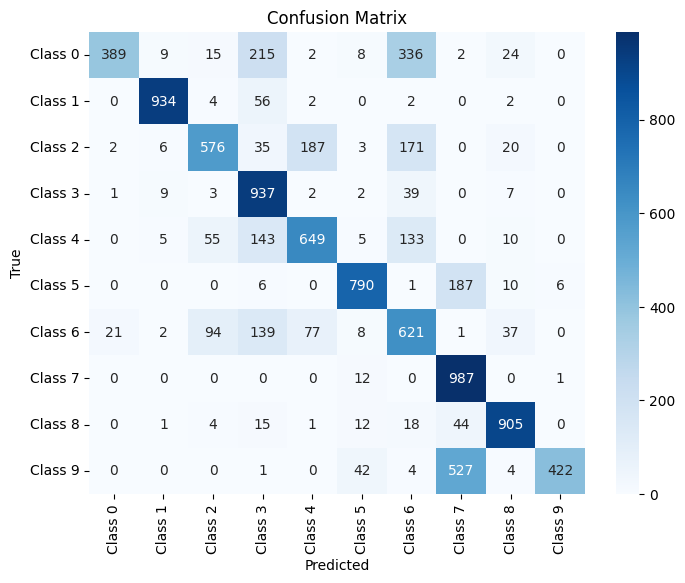

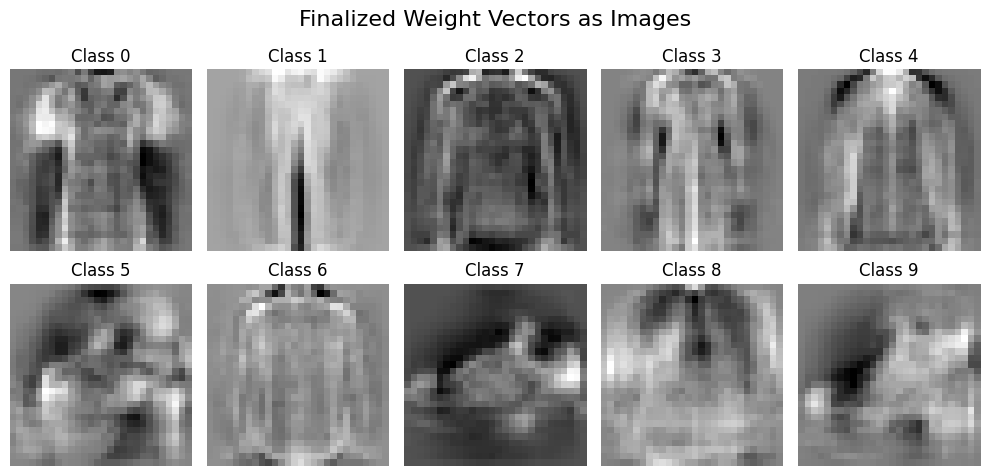


Comment on Weight Images:
Each weight image represents the learned features for a specific digit (0-9).
The weights are visualized as 28x28 grayscale images, corresponding to the MNIST input dimensions.
The images are blurry but show distinguishable patterns associated with each class.
For example, the weight image for the digit '0' may show a circular shape, while '1' has a vertical line.
These patterns represent the features the model has learned to identify the respective classes.

Precision, Recall, F1 Score, and F2 Score for Each Class:
Class 0: Precision=0.9419, Recall=0.3890, F1 Score=0.5506, F2 Score=0.4407
Class 1: Precision=0.9669, Recall=0.9340, F1 Score=0.9502, F2 Score=0.9404
Class 2: Precision=0.7670, Recall=0.5760, F1 Score=0.6579, F2 Score=0.6062
Class 3: Precision=0.6057, Recall=0.9370, F1 Score=0.7358, F2 Score=0.8446
Class 4: Precision=0.7054, Recall=0.6490, F1 Score=0.6760, F2 Score=0.6596
Class 5: Precision=0.8957, Recall=0.7900, F1 Score=0.8395, F2 Score=0.8091
C

In [22]:
train_optimal_model_with_metrics(X_train, y_train, X_val, y_val, X_test, y_test)